## Imports

In [12]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

## Set random seed for reproducibility

In [13]:
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Data Loading

In [ ]:

data_dir = "../data/balanced_data_by_region"
saved_models_dir = "./saved_models"
os.makedirs(saved_models_dir, exist_ok=True)


transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])


dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)


dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

## Architecture Definition

In [ ]:

class ConformerTiny(nn.Module):
    def __init__(self, img_size=128, num_classes=5, embed_dim=32, num_heads=4, num_transformer_layers=1):
        super(ConformerTiny, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU()
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_transformer_layers
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        
        x = self.conv(x)
        b, c, h, w = x.shape
        x = x.view(b, c, -1).permute(2, 0, 1)  

        
        x = self.transformer(x)

        
        x = x.mean(dim=0)  
        x = self.fc(x)
        return x

## Function Definition

In [ ]:

def save_model(epoch, model, optimizer, path, best=False):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, path)
    if best:
        best_path = os.path.join(saved_models_dir, f"best_model_epoch{epoch}.pth")
        torch.save(state, best_path)

def load_model(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']


def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
    return running_loss / len(dataloader.dataset), correct / len(dataloader.dataset)


## Initialization

In [ ]:

learning_rate = 1e-3
batch_size = 64
num_epochs = 20

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConformerTiny(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\jonec\miniconda3\envs\general_ai\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Training

In [ ]:

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


best_val_loss = float('inf')

for epoch in range(num_epochs):
    
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    
    train_loss, train_acc = validate(model, train_loader, criterion, device)
    train_accuracies.append(train_acc)

    
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    
    save_model(epoch, model, optimizer, os.path.join(saved_models_dir, f"epoch{epoch+1}.pth"))

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_model(epoch+1, model, optimizer, os.path.join(saved_models_dir, f"epoch{epoch+1}.pth"), best=True)


Epoch 1/20 - Train Loss: 1.3672, Train Acc: 0.4135, Val Loss: 1.3793, Val Acc: 0.3998
Epoch 2/20 - Train Loss: 1.3383, Train Acc: 0.4261, Val Loss: 1.3578, Val Acc: 0.4179
Epoch 3/20 - Train Loss: 1.2353, Train Acc: 0.4973, Val Loss: 1.2525, Val Acc: 0.4913
Epoch 4/20 - Train Loss: 1.2447, Train Acc: 0.4953, Val Loss: 1.2688, Val Acc: 0.4886
Epoch 5/20 - Train Loss: 1.1585, Train Acc: 0.5303, Val Loss: 1.1982, Val Acc: 0.5125
Epoch 6/20 - Train Loss: 1.1378, Train Acc: 0.5403, Val Loss: 1.1733, Val Acc: 0.5230
Epoch 7/20 - Train Loss: 1.1064, Train Acc: 0.5555, Val Loss: 1.1448, Val Acc: 0.5436
Epoch 8/20 - Train Loss: 1.1271, Train Acc: 0.5454, Val Loss: 1.1569, Val Acc: 0.5335
Epoch 9/20 - Train Loss: 1.0878, Train Acc: 0.5578, Val Loss: 1.1441, Val Acc: 0.5341
Epoch 10/20 - Train Loss: 1.0153, Train Acc: 0.5961, Val Loss: 1.0677, Val Acc: 0.5773
Epoch 11/20 - Train Loss: 0.9983, Train Acc: 0.6015, Val Loss: 1.0698, Val Acc: 0.5726
Epoch 12/20 - Train Loss: 1.0232, Train Acc: 0.5956,

# Testing

In [ ]:

test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Test Loss: 1.0175, Test Acc: 0.6024


## Plotting

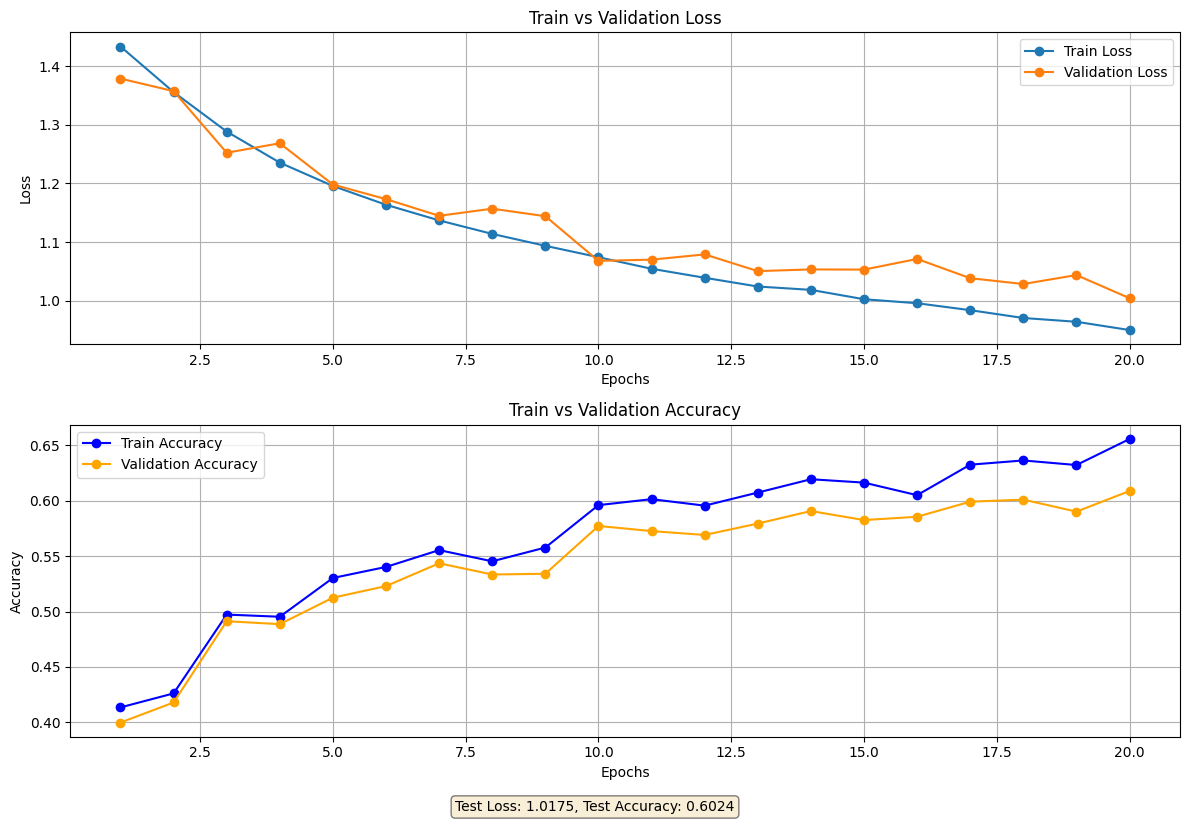

Loss and Accuracy plot saved at: ./saved_models\loss_accuracy_plot.png


In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))


plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)


plt.figtext(0.5, -0.02, f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}", 
            ha="center", fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


plot_path = os.path.join(saved_models_dir, "loss_accuracy_plot.png")
plt.tight_layout()
plt.savefig(plot_path, bbox_inches="tight")
plt.show()

print(f"Loss and Accuracy plot saved at: {plot_path}")